In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

logreg = LogisticRegression()

In [3]:
### Read in the training data
titanic_training = pd.read_csv('data/train_data.csv', index_col='PassengerId')
print('-'*40)
titanic_training.info()

----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
# there's a few columns with strings that we can convert to categorical numbers
titanic_training['Sex'] = titanic_training['Sex'].map({'male':0, 'female':1})
titanic_training['Embarked'] = titanic_training['Embarked'].map({'C':0, 'Q':1, 'S':2})
titanic_training['has_Cabin?'] = titanic_training['Cabin'].isna()
titanic_training['has_Cabin?'] = titanic_training['has_Cabin?'].map({False:0,True:1})

# 'Cabin' is a string value with a combo of a letter then numbers. Let's just extract whatever letter they were on first
# fill any missing values in Cabin with just the letter X to map to a number later
titanic_training['Cabin'] = titanic_training['Cabin'].fillna('X')
titanic_training['Cabin_level'] = titanic_training['Cabin'].apply(lambda value: value[0])

# now let;s just map it back to numberical values
titanic_training['Cabin_level'] = titanic_training['Cabin_level'].map({'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'T':7,'X':8})
titanic_training['Cabin'].unique()

array(['X', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
# I think trying to extract any possible 'title' from name might be interesting as well
print(titanic_training['Name'].head(10))
test_value = titanic_training.iloc[10]['Name']

# alright, so generally the format is last_name, 'TITLE'. then the name. this should be fine to extract
titanic_training['title_raw'] = titanic_training['Name'].apply(lambda name: name.split(',')[1:][0].split('.')[0].strip())

In [213]:
#let's check the title work we just did and see if caught a good amount
titanic_training.groupby('title_raw').size()

title_raw
Capt              1
Col               2
Don               1
Dr                7
Jonkheer          1
Lady              1
Major             2
Master           40
Miss            182
Mlle              2
Mme               1
Mr              517
Mrs             125
Ms                1
Rev               6
Sir               1
the Countess      1
dtype: int64

In [214]:
# not bad! let's check out a few weird ones
titanic_training.loc[titanic_training['title_raw']=='Sir']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,has_Cabin?,Cabin_level,title_raw
PassengerId,,,,,,,,,,,,,,
600,1,1,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",0,49.0,1,0,PC 17485,56.9292,A20,0.0,0,0,Sir


In [215]:
# okay I can clean these up a bit through map
title_map = {'Capt':'other', 'Col':'other', 'Don':'other', 'Dr':'other',
            'Jonkheer':'other', 'Lady':'other','Major':'other', 'Ms':'Miss',
             'Mlle':'Miss', 'Mme':'Mrs', 'Rev':'other', 'Sir':'other', 'the Countess':'other',
            'Mr':'Mr', 'Miss':'Miss', 'Mrs':'Mrs', 'Master':'Master'}
titanic_training['title_group'] = titanic_training['title_raw'].map(title_map)

title_training_map = {'Miss':0, 'Mr':1,'Mrs':2, 'Master':3, 'other':4}
titanic_training['title_group'] = titanic_training['title_group'].map(title_training_map)


In [218]:
# now let's take a look at tickets, just to see if there's anyhting interesting there
print(titanic_training.groupby('Ticket').size().sort_values(ascending=False))

# I want to create a feature that shares how many total passengers where on that ticket with folks. Could be similar to siblings & parents, but worth a look!
def find_passengers_on_ticket(ticket_number):
    filter_df = titanic_training.loc[titanic_training['Ticket']==ticket_number]
    return len(filter_df)

titanic_training['num_shared_ticket'] = titanic_training['Ticket'].apply(lambda ticket_number: find_passengers_on_ticket(ticket_number))

# through analysis, I learned the 'Fare' is for the total ticket. So I'd like to add a 'per_person_fare'
titanic_training['per_person_fare'] = titanic_training.apply(lambda row: row['Fare'] / row['num_shared_ticket'], axis=1)

# let's do the same with cabin
def find_passengers_in_cabin(cabin):
    filter_df = titanic_training.loc[(titanic_training['Cabin']==cabin) & (~titanic_training['Cabin'].isna())]
    return len(filter_df)

titanic_training['num_shared_cabin'] = titanic_training['Cabin'].apply(lambda cabin: find_passengers_in_cabin(cabin))
titanic_training['num_shared_cabin'].fillna(0, inplace=True)

Ticket
1601        7
CA. 2343    7
347082      7
CA 2144     6
347088      6
           ..
345572      1
345364      1
343276      1
343275      1
347464      1
Length: 681, dtype: int64


In [219]:
# let's also add a feature that calculates their total family
titanic_training['family_aboard'] = titanic_training.apply(lambda row: row['SibSp'] + row['Parch'], axis=1)

In [220]:
### Also there are some blank values for 'Age'
# let's just fill them in with the average age
average_age = titanic_training['Age'].mean()

titanic_training.loc[titanic_training['Age'].isna(), 'Age'] = average_age

# now that we've done that, let's add a feature checks if they were a child or not
titanic_training['is_Child?'] = titanic_training['Age'].apply(lambda age: 1 if age <= 12 else 0)

In [221]:
# Lastly there's two embarked missing
# let's check those out
titanic_training.loc[titanic_training['Embarked'].isna()]

# I'm just going to set all of the missing 'Embarked' values to 3
titanic_training.loc[titanic_training['Embarked'].isna(), 'Embarked'] = 3

In [222]:
# let's just double check that we have added the features I wanted and there are no more missing values
titanic_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Survived           891 non-null    int64  
 1   Pclass             891 non-null    int64  
 2   Name               891 non-null    object 
 3   Sex                891 non-null    int64  
 4   Age                891 non-null    float64
 5   SibSp              891 non-null    int64  
 6   Parch              891 non-null    int64  
 7   Ticket             891 non-null    object 
 8   Fare               891 non-null    float64
 9   Cabin              891 non-null    object 
 10  Embarked           891 non-null    float64
 11  has_Cabin?         891 non-null    int64  
 12  Cabin_level        891 non-null    int64  
 13  title_raw          891 non-null    object 
 14  title_group        891 non-null    int64  
 15  num_shared_ticket  891 non-null    int64  
 16  per_person_fare    891 non

In [287]:
# let's just subset all except the 'Survived' Column, since that's what we are trying to predict
cols_to_exclude = ['Survived', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Fare', 'title_raw', 'survival_prediction']
feature_cols = [col for col in titanic_training.columns if col not in cols_to_exclude]

X = titanic_training[feature_cols]
y = titanic_training['Survived']

# now we need to scale our X
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

logreg.fit(X_scaled,y)
titanic_training['survival_prediction'] = logreg.predict(X_scaled)

# let's check the accuracy score
logreg_accuracy = accuracy_score(titanic_training['Survived'], titanic_training['survival_prediction'])

In [288]:
logreg_proba = logreg.predict_proba(X_scaled)[:,1]

# let's check out a confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true=titanic_training['Survived'], y_pred=logreg_proba > .5).ravel()

logreg_matrix = (tn, fp, fn, tp)

In [289]:
# lets do some Feaature Importance work to improve this
# let's get a sense of how many estimators I need in a random forest
k_value = len(feature_cols)

# probability of survivalin the training data
survival_prob = len(titanic_training.loc[titanic_training['Survived']==1]) / len(titanic_training)
print("Total Survival Rate from Training Data: ", round(survival_prob, 3))

Total Survival Rate from Training Data:  0.384


In [290]:
n_estimators = round((k_value * 10) / survival_prob)

rf = RandomForestRegressor(n_estimators=n_estimators)
rf.fit(X_scaled, y)

features_sorted = rf.feature_importances_.argsort()

<BarContainer object of 12 artists>

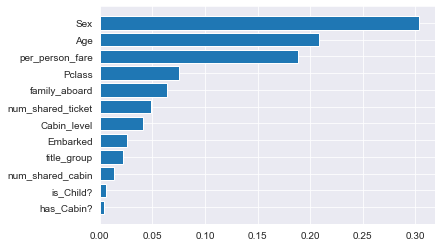

In [291]:
titanic_target_features = titanic_training.loc[:, feature_cols]

plt.barh(titanic_target_features.columns[features_sorted], rf.feature_importances_[features_sorted])

<AxesSubplot:>

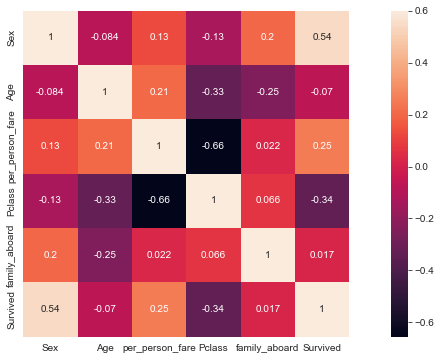

In [292]:
# let's do  quick heat map too to see how these features correlate
correlation_features = ['Sex', 'Age', 'per_person_fare', 'Pclass', 'family_aboard', 'Survived']
plt.figure(figsize=(15,6))
sns.color_palette('mako')
sns.heatmap(titanic_training[correlation_features].corr(), vmax=0.6, square=True, annot=True)

In [293]:
# alright, maybe this is backwards, but let's just explore some general trends between some features individually
print("Sex grouped by Survival Rate\n")
print("-"*30)
titanic_training[['Sex', 'Survived']].groupby('Sex').mean().sort_values('Survived', ascending=False)

Sex grouped by Survival Rate

------------------------------


,Survived
Sex,
1,0.742038
0,0.188908


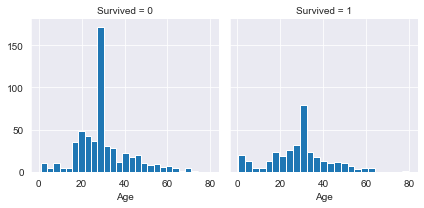

In [294]:
# so overwhelmingly, women survived the disaster more often
# let's check out surival rates by age
g = sns.FacetGrid(titanic_training, col='Survived')
g.map(plt.hist, 'Age', bins=25)

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

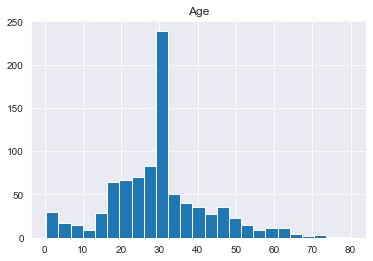

In [298]:
# just for comparisons sake, let's just look at the total universise from the training set
titanic_training.hist('Age', bins=25)

In [299]:
# alright, so just eyeballing this, those who died skewed a bit younger than those who survived

In [300]:
# how about by passenger class
print("Passenger Class grouped by Survival Rate\n")
print("-"*40)
titanic_training[['Pclass', 'Survived']].groupby('Pclass').mean().sort_values('Survived', ascending=False)

Passenger Class grouped by Survival Rate

----------------------------------------


,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


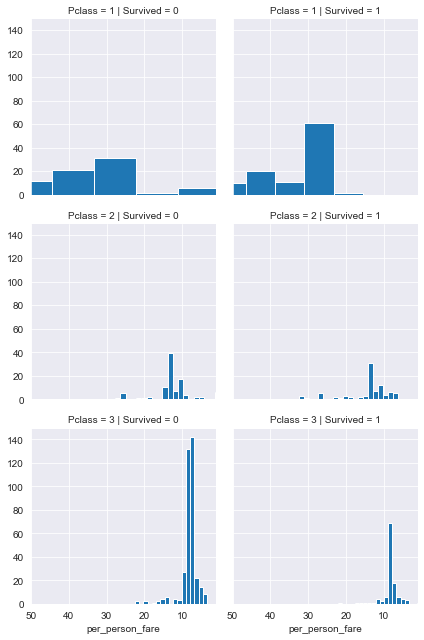

In [301]:
# let's check out surival rates by Fare
g = sns.FacetGrid(titanic_training, col='Survived', row='Pclass',xlim=50)
g.map(plt.hist, 'per_person_fare', bins=20)

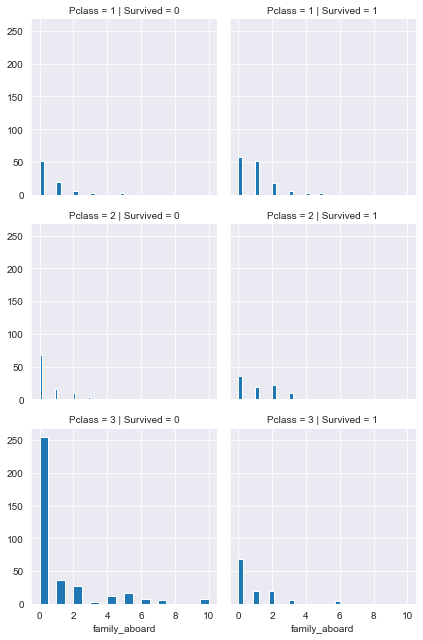

In [302]:
# there's some definite economic disparity here (sadly)
# it's worth cross checking family_aboard as this might also suggest that a ton of people who died were by themselves
g = sns.FacetGrid(titanic_training, col='Survived', row='Pclass')
g.map(plt.hist, 'family_aboard', bins=20)

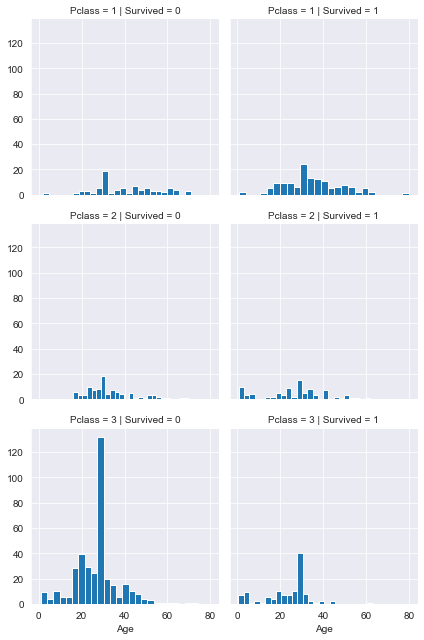

In [303]:
#let's revist age with pclass
g = sns.FacetGrid(titanic_training, col='Survived', row='Pclass')
g.map(plt.hist, 'Age', bins=25)

In [304]:
### alright, let's just mess around a bit more and see if other models can improve out accuracy score
print('Accuracy score from simple Logistric Regression: {}%'.format(round(logreg_accuracy, 3) * 100))

Accuracy score from simple Logistric Regression: 82.3%


In [330]:
# let's import a few other models to mess around with
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [324]:
# alright, let's start with a Random Forest
random_forest = RandomForestClassifier(random_state=6109)
random_forest.fit(X_scaled, y)
random_forest.predict(X_scaled)
random_forest.score(X_scaled, y)

0.9876543209876543

<BarContainer object of 12 artists>

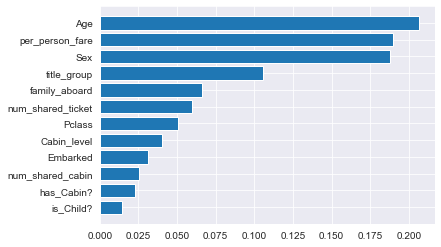

In [325]:
features_sorted = random_forest.feature_importances_.argsort()
plt.barh(titanic_target_features.columns[features_sorted], random_forest.feature_importances_[features_sorted])

In [326]:
# alright, let's start with a Random Forest
decision_tree = DecisionTreeClassifier(random_state=6109)
decision_tree.fit(X_scaled, y)
decision_tree.predict(X_scaled)
decision_tree.score(X_scaled, y)

0.9876543209876543

<BarContainer object of 12 artists>

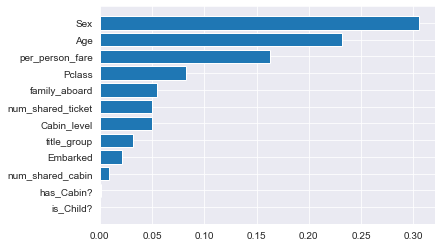

In [327]:
features_sorted = decision_tree.feature_importances_.argsort()
plt.barh(titanic_target_features.columns[features_sorted], decision_tree.feature_importances_[features_sorted])

In [337]:
# alright, let's start with a SVC
svc = SVC(random_state=6109)
svc.fit(X_scaled, y)
svc.predict(X_scaled)
svc.score(X_scaled, y)

0.8428731762065096

In [336]:
# alright, let's start with a SVC
knn = KNeighborsClassifier()
knn.fit(X_scaled, y)
knn.predict(X_scaled)
knn.score(X_scaled, y)

0.8754208754208754